![example](images/director_shot.jpeg)

# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [22]:
# Import Relevant Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image

# Neural network libraries

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, losses, metrics, Input
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
np.random.seed(42)

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [2]:
# # Running in Google Colab
# from google.colab import drive

# drive.mount('/content/gdrive')
# root_path = 'gdrive/My Drive/Colab Notebooks/Pneumonia/' 

In [3]:
# Running locally
root_path = '../'

In [4]:
train_path = root_path + 'data/chest_xray/train/'
test_path = root_path + 'data/chest_xray/test/'

In [5]:
idg = ImageDataGenerator(rescale=1/255, validation_split=0.20)
train_set = idg.flow_from_directory(train_path, 
                                    target_size=(128, 128), 
                                    color_mode='grayscale', 
                                    class_mode='binary', 
                                    subset='training')
validation_set = idg.flow_from_directory(train_path, 
                                         target_size=(128, 128), 
                                         color_mode='grayscale', 
                                         class_mode='binary', 
                                         subset='validation')
test_set = idg.flow_from_directory(test_path, 
                                   target_size=(128,128), 
                                   color_mode='grayscale', 
                                   class_mode='binary', 
                                   shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
classes = pd.DataFrame(train_set.classes)
class_dict = {0:'Normal', 1:'Pneumonia'}
classes[0] = classes[0].map(class_dict)
classes.value_counts()

Pneumonia    3100
Normal       1073
dtype: int64

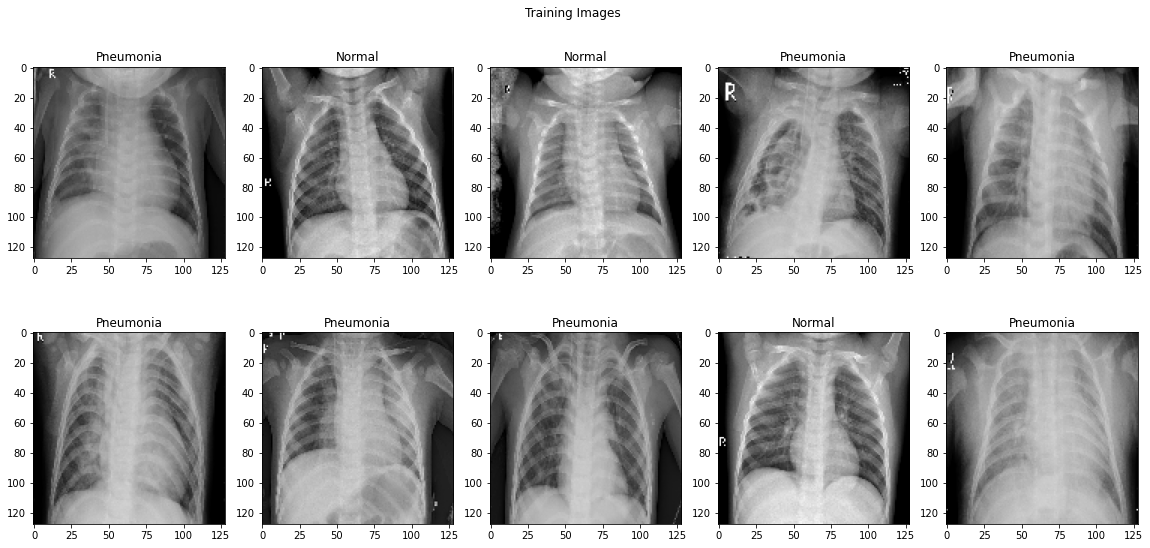

In [40]:
# # Visualize
train_images = train_set.next()
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

#train_images

for i in range(10):
    # Load image into numpy array and re-scale
    img = np.array(train_images[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.set_title(class_dict[train_images[1][i]])
    ax.imshow(img, cmap ='gray')
fig.suptitle('Training Images')
plt.tight_layout()
plt.show()

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### DummyClassifier

In [8]:
train_target_size = train_set.image_shape[0:2]
train_batch_size  = train_set.n

test_target_size  = test_set.image_shape[0:2]
test_batch_size   = test_set.n



# Batch size set to the number of images found above in order to not batch data for the dummy model. Validation set not needed for dummy model
train_set_dummy = idg.flow_from_directory(train_path,
                                          target_size=train_target_size,
                                          color_mode='grayscale', 
                                          class_mode='binary', 
                                          subset='training', 
                                          batch_size=train_batch_size)

test_set_dummy  = idg.flow_from_directory(test_path, 
                                          target_size=test_target_size,
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          shuffle=False,
                                          batch_size=test_batch_size)

# Split train and test dummy sets into images and corresponding labels for dummy model training
train_images, train_labels = next(train_set_dummy)
test_images, test_labels = next(test_set_dummy)

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
baseline_model = DummyClassifier(strategy= 'most_frequent')
baseline_model.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

Baseline accuracy: 0.625
Baseline recall: 1.0


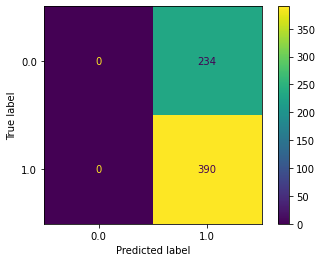

In [10]:
y_base_pred = baseline_model.predict(test_images)

base_accuracy = baseline_model.score(test_images, test_labels)
base_recall = recall_score(test_labels, y_base_pred)
print(f"Baseline accuracy: {base_accuracy}")
print(f"Baseline recall: {base_recall}")

plot_confusion_matrix(baseline_model, test_images, test_labels);

### First simple model

In [52]:
# here you run your code to model the data
simple_model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(20, activation='sigmoid'),
    layers.Dense(12, activation='sigmoid'),
    layers.Dense(8, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

# simple_model.add(Flatten(input_shape = (128, 128, 1)))
# simple_model.add(Dense(20, activation= 'sigmoid'))
# simple_model.add(Dense(12, activation= 'sigmoid'))
# simple_model.add(Dense(8, activation= 'sigmoid'))
# simple_model.add(Dense(1, activation='sigmoid'))

simple_model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])

In [53]:
results = simple_model.fit(train_set, #train_set_aug, 
                           epochs=10, 
                           batch_size=None, 
                           verbose=1, 
                           validation_data=validation_set)

Epoch 1/10
131/131 [==============================] - 39s 294ms/step - loss: 0.6155 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.5095 - val_loss: 0.5852 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.5000
Epoch 2/10
131/131 [==============================] - 38s 290ms/step - loss: 0.5775 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.4960 - val_loss: 0.5724 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_au

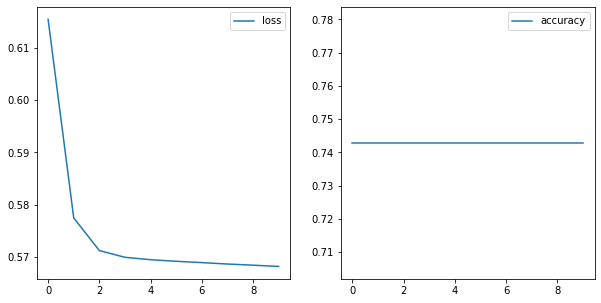

In [54]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

In [55]:
# here you run your code to model the data
simple_model_v2 = models.Sequential([
    layers.Input(shape=(128, 128, 1)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(320, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simple_model_v2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])

simple_model_v2.output_shape

(None, 1)

In [ ]:
results_v2 = simple_model_v2.fit(train_set, #train_set_aug, 
                           epochs=50, 
                           batch_size=32, 
                           validation_data=validation_set)

Epoch 1/50
 71/131 [===============>..............] - ETA: 15s - loss: 0.6240 - accuracy: 0.7500 - recall: 0.9237 - precision: 0.7823 - true_positives: 1574.0000 - true_negatives: 130.0000 - false_positives: 438.0000 - false_negatives: 130.0000 - auc: 0.7135

In [ ]:
sigmoid_loss = results_v2.history['loss']
sigmoid_accuracy = results_v2.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_v2.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results_v2.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***